In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import pandas as pd
import numpy as np
import locale
import matplotlib.pyplot as plt
from pathlib import Path
from helpers import (
    filter_region_year,
    REGIJE_FILTER,
    REGION_COLORS
)
import seaborn as sns
from scipy.stats import ttest_ind, shapiro, probplot
import matplotlib.colors as mcolors
import matplotlib.cm as cm


In [18]:
NEVARNE_SNOVI = ["SO2", "PM10", "NO2"]
WIDE_PATH = Path("podatki/wide_df.csv")

locale.setlocale(locale.LC_ALL, "sl_SI.utf8")

df = pd.read_csv(WIDE_PATH, parse_dates=["Datum"])


In [43]:
def plot_average_value_changes(stats_df: pd.DataFrame, pollutant: str):
    """
    Visualizes the change in average pollutant value for each region before and after the directive.

    Args:
        stats_df (pd.DataFrame): DataFrame returned by calculate_stats,
                                    containing statistics with 'Regija' and 'Povprečna vrednost' columns.
        pollutant (str): The name of the pollutant being analyzed.
    """
    diff_vals = 100 * (stats_df["povprečje [po]"] - stats_df["povprečje [pred]"]) / stats_df['povprečje [pred]']
    diff_df = pd.DataFrame(
        data=diff_vals, index=stats_df.index, columns=["Razlika"]
    ).reset_index()

    norm = mcolors.TwoSlopeNorm(vmin=-100, vcenter=0, vmax=100)
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "custom_div", ["green", "white", "red"]
    )
    colors = [cmap(norm(val)) for val in diff_df["Razlika"]]
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot
    sns.barplot(
        x="Razlika",
        y="Regija",
        data=diff_df,
        hue="Regija",
        palette=colors,
        legend=False,
    )

    ax.axvline(0, color="black", linestyle="--", linewidth=1)
    ax.set_xlim(-100, 100)

    # Add value labels
    for i, row in diff_df.iterrows():
        ax.text(
            row["Razlika"] if row["Razlika"] < 0 else row["Razlika"] + 1.5,
            i,
            f'{row["Razlika"]:.1f}%',
            color="black",
            ha="right" if row["Razlika"] < 0 else "left",
            va="center",
        )

    ax.set_title(f"Odstotek spremembe za {pollutant}")
    ax.set_xlabel("Sprememba (%)")
    ax.set_ylabel("Regija")

    plt.tight_layout()
    plt.savefig(f"grafi/razlika_{pollutant}.png")
    plt.show()


def plot_qq(pre_data, post_data, pollutant, region='Slovenija'):
    """Plots Q-Q plots for 'before' and 'after' data in the same figure."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 6)) 
    plt.rcParams['font.family'] = 'sans-serif'

    # Q-Q plot for 'before' data
    probplot(pre_data, dist="norm", plot=axes[0])
    axes[0].set_title("Pred direktivo", fontsize=12) 
    axes[0].set_xlabel("Teoretični kvantili", fontsize=10)  
    axes[0].set_ylabel("Vzorčni kvantili", fontsize=10)  

    # Q-Q plot for 'after' data
    probplot(post_data, dist="norm", plot=axes[1])
    axes[1].set_title("Po direktivi", fontsize=12)  
    axes[1].set_xlabel("Teoretični kvantili", fontsize=10)  
    axes[1].set_ylabel("Vzorčni kvantili", fontsize=10) 

    fig.suptitle(f"Q-Q graf za {pollutant} ({region})", fontsize=14)  

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  
    # plt.savefig(f"grafi/qqplot_{pollutant}_{region}.png")  
    plt.show()


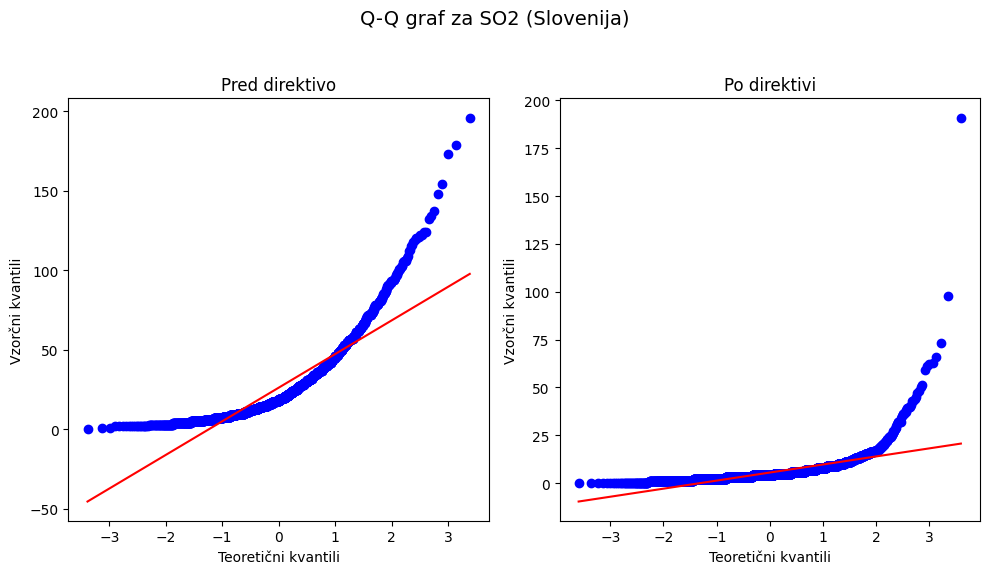

In [44]:
from scipy.stats import mannwhitneyu, kstest


def split_directive(df: pd.DataFrame):
    leto = pd.to_datetime(REGIJE_FILTER[df.columns.to_list()[-1]]["direktiva"])
    pre_ind = df["Datum"] < leto
    return df[pre_ind], df[~pre_ind]


def get_significance(p):
    return "*" * sum(p < t for t in [0.05, 0.01, 0.001])


def format_p(p):
    return "< 0.001***" if p < 0.001 else f"{p:.3g}{get_significance(p)}"


def calculate_stats(df: pd.DataFrame, snov):
    """Calculates basic statistics for each region in the given df"""
    pre, post = split_directive(df)

    def aggregate_stats(pre: pd.DataFrame, post: pd.DataFrame) -> pd.DataFrame:
        pre_grouped = pre.groupby("Regija")[snov].agg(
            n="count", povprečje="mean", mediana="median", std="std"
        )
        post_grouped = post.groupby("Regija")[snov].agg(
            n="count", povprečje="mean", mediana="median", std="std"
        )
        combined = pre_grouped.join(post_grouped, rsuffix=" [po]", lsuffix=" [pred]")

        ordered_columns = [
            "n [pred]",
            "n [po]",
            "povprečje [pred]",
            "povprečje [po]",
            "mediana [pred]",
            "mediana [po]",
            "std [pred]",
            "std [po]",
        ]
        combined = combined[ordered_columns]
        return combined

    basic_stats = aggregate_stats(pre, post)

    fig, axes = plt.subplots(1, 2)

    sns.histplot(pre[snov], ax=axes[0])
    axes[0].set_ylabel("Št. meritev")
    axes[0].set_xlabel(f"{snov} µg/m3")
    axes[0].set_title(f"Porazdelitev {snov} (pred)")

    sns.histplot(post[snov], ax=axes[1])
    axes[1].set_xlabel(f"{snov} µg/m3")
    axes[1].set_ylabel("")
    axes[1].set_title(f"Porazdelitev {snov} (po)")

    plt.tight_layout()
    plt.savefig(f"grafi/porazdelitev_{snov}.png")
    plt.show()

    basic_stats.sort_index(inplace=True)
    basic_stats.loc["Slovenija"] = [
        pre[snov].size,
        post[snov].size,
        pre[snov].mean(),
        post[snov].mean(),
        pre[snov].median(),
        post[snov].median(),
        pre[snov].std(),
        post[snov].std(),
    ]

    return basic_stats


def perform_stat_tests(df: pd.DataFrame, direktiva: str, snov: str):
    pre_ind = df["Datum"] < pd.to_datetime(direktiva)
    pre = df[pre_ind].copy()
    post = df[~pre_ind].copy()

    results = []
    kstesti = {}

    for region in df["Regija"].unique():
        pre_vals = pre.loc[pre["Regija"] == region, snov].dropna()
        post_vals = post.loc[post["Regija"] == region, snov].dropna()

        kstesti[region] = kstest(pre_vals, post_vals)

        test_stat, p_value = mannwhitneyu(pre_vals, post_vals, alternative="two-sided")

        results.append(
            {
                "Regija": region,
                "Mann-Whitney U": test_stat,
                "p-vrednost": p_value,
            }
        )

    kstesti_df = (
        pd.DataFrame(kstesti)
        .transpose()
        .set_axis(["KS vrednost", "p-vrednost"], axis=1)
    )
    kstesti_df.sort_values(by="p-vrednost")
    total_ks, total_p = kstest(pre[snov], post[snov])
    kstesti_df.loc["Slovenija"] = [total_ks, total_p]
    kstesti_df["p-vrednost"] = kstesti_df["p-vrednost"].apply(format_p)

    results_df = pd.DataFrame(results).sort_values(by="p-vrednost")

    results_df["p-vrednost"] = results_df["p-vrednost"].apply(format_p)
    return results_df, kstesti_df


for i, snov in enumerate(NEVARNE_SNOVI):
    direktiva = REGIJE_FILTER[snov]["direktiva"]
    filtered_df = filter_region_year(df, snov).dropna()
    
    pre, post = split_directive(filtered_df)
    pre_vals = pre[snov]
    post_vals = post[snov]

    plot_qq(pre_vals, post_vals,snov)

    

    
    
    
    # basic_stats = calculate_stats(filtered_df, snov)
    # display(basic_stats)

    # mann_tests, ks_tests = perform_stat_tests(filtered_df, direktiva, snov)
    # display(ks_tests)
    # display(mann_tests)
    
    break
    